## Please upvote if you liked my work :)

# Importing Libraries and Data

In [1]:
# data processing
import numpy as np
import pandas as pd

# model building
import sklearn as sk
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, matthews_corrcoef

# pytorch
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

# feature selection
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


## Importing train and test data

In [2]:
# importing training data
train = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
train.head(2)

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w


In [3]:
# importing test data
test = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")
test.head(2)

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a


# Data Analysis

## Data Information

In [4]:
train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    3116945 non-null  int64  
 1   class                 3116945 non-null  object 
 2   cap-diameter          3116941 non-null  float64
 3   cap-shape             3116905 non-null  object 
 4   cap-surface           2445922 non-null  object 
 5   cap-color             3116933 non-null  object 
 6   does-bruise-or-bleed  3116937 non-null  object 
 7   gill-attachment       2593009 non-null  object 
 8   gill-spacing          1858510 non-null  object 
 9   gill-color            3116888 non-null  object 
 10  stem-height           3116945 non-null  float64
 11  stem-width            3116945 non-null  float64
 12  stem-root             359922 non-null   object 
 13  stem-surface          1136084 non-null  object 
 14  stem-color            3116907 non-

In [5]:
test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    2077964 non-null  int64  
 1   cap-diameter          2077957 non-null  float64
 2   cap-shape             2077933 non-null  object 
 3   cap-surface           1631060 non-null  object 
 4   cap-color             2077951 non-null  object 
 5   does-bruise-or-bleed  2077954 non-null  object 
 6   gill-attachment       1728143 non-null  object 
 7   gill-spacing          1238369 non-null  object 
 8   gill-color            2077915 non-null  object 
 9   stem-height           2077963 non-null  float64
 10  stem-width            2077964 non-null  float64
 11  stem-root             239952 non-null   object 
 12  stem-surface          756476 non-null   object 
 13  stem-color            2077943 non-null  object 
 14  veil-type             106419 non-n

## Dropping NaN

In [6]:
# those columns nearly have no useful information 
mostly_nan_cols = ['stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color']
train.drop(mostly_nan_cols, axis=1, inplace=True)
test.drop(mostly_nan_cols, axis=1, inplace=True)

In [7]:
# I used to drop those columns with many NaN values while using Random forest
# Using neural network, I fill them with mode instead
many_nan_cols = ['gill-spacing', 'cap-surface', 'gill-attachment', 'ring-type']
# train.drop(many_nan_cols, axis=1, inplace=True)
# test.drop(many_nan_cols, axis=1, inplace=True)

In [8]:
# Viewing number of NaN values
pd.DataFrame([train.isna().sum(), test.isna().sum()]).T

,0,1
id,0.0,0.0
class,0.0,NaN
cap-diameter,4.0,7.0
cap-shape,40.0,31.0
cap-surface,671023.0,446904.0
cap-color,12.0,13.0
does-bruise-or-bleed,8.0,10.0
gill-attachment,523936.0,349821.0
gill-spacing,1258435.0,839595.0
gill-color,57.0,49.0


## Removing Outliers

In [9]:
# Number of categories in each column
train.nunique()

id                      3116945
class                         2
cap-diameter               3913
cap-shape                    74
cap-surface                  83
cap-color                    78
does-bruise-or-bleed         26
gill-attachment              78
gill-spacing                 48
gill-color                   63
stem-height                2749
stem-width                 5836
stem-color                   59
has-ring                     23
ring-type                    40
habitat                      52
season                        4
dtype: int64

In [10]:
# all categorical columns
categorical_cols = many_nan_cols + ['cap-shape', 'cap-color', 'does-bruise-or-bleed', 'gill-color', 'stem-color', 'has-ring', 'habitat', 'season']

# replacing any categories with value_counts less than 100 with 'rare'
# because those are very small number of records it won't affect the distribution of the data 
for c in categorical_cols:
    col_count = train[c].value_counts()
    rare_keys = col_count[col_count<100].index
    train[c] = train[c].replace(rare_keys, 'rare')
    
    col_count = test[c].value_counts()
    rare_keys = col_count[col_count<100].index
    test[c] = test[c].replace(rare_keys, 'rare')

# Number of categories in each column
train.nunique()

id                      3116945
class                         2
cap-diameter               3913
cap-shape                     8
cap-surface                  12
cap-color                    13
does-bruise-or-bleed          3
gill-attachment               8
gill-spacing                  4
gill-color                   13
stem-height                2749
stem-width                 5836
stem-color                   14
has-ring                      3
ring-type                     9
habitat                       9
season                        4
dtype: int64

## Filling NaNs

In [11]:
# filling NaN values with the mode because most of columns are categorical
for c in train.columns:
    train[c] = train[c].fillna(train[c].mode().values[0])
train.isna().sum()

id                      0
class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

In [12]:
# filling NaN values with the mode because most of columns are categorical
for c in test.columns:
    test[c] = test[c].fillna(test[c].mode().values[0])
test.isna().sum()

id                      0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

# Model

## Data Spliting

In [13]:
# droping the target column and 'id' because it isn't a feature
X = train.drop(['class', 'id'], axis=1)
y = train['class']
X.head(2)

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,8.80,f,s,u,f,a,c,w,4.51,15.39,w,f,f,d,a
1,4.51,x,h,o,f,a,c,n,4.79,6.48,o,t,z,d,w


In [14]:
# using 70% of the data as training data and 30% as test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

## Converting Categories to Intgers

In [15]:
# prepare output data by converting categories into numbers
oe = OrdinalEncoder()
oe.fit(X_train[categorical_cols])
X_train[categorical_cols] = oe.transform(X_train[categorical_cols])
X_test[categorical_cols] = oe.transform(X_test[categorical_cols])
test[categorical_cols] = oe.transform(test[categorical_cols])

test.head(2)

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,3116945,8.64,7.0,9.0,5.0,2.0,0.0,0.0,11.0,11.13,17.12,12.0,2.0,2.0,0.0,0.0
1,3116946,6.90,3.0,9.0,6.0,0.0,0.0,0.0,12.0,1.27,10.75,6.0,0.0,1.0,0.0,0.0


In [16]:
# prepare input data by converting the letters in target column into numbers
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

train.head(2)

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,w,f,f,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,o,t,z,d,w


## Feature Selection

Feature 0: 20197.118520
Feature 1: 10012.712954
Feature 2: 50523.701865
Feature 3: 39612.848786
Feature 4: 32995.118490
Feature 5: 8665.637682
Feature 6: 5011.635136
Feature 7: 20938.868347
Feature 8: 22027.600984
Feature 9: 8278.886174
Feature 10: 4959.358699
Feature 11: 10198.071977


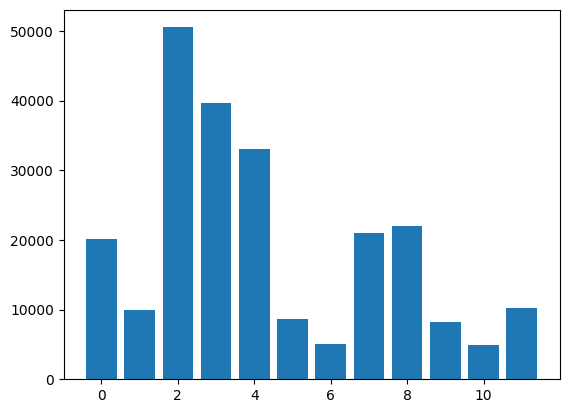

In [17]:
# feature selection
def select_features(X_train, y_train):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs


# applying feature selection on the training data
X_train_fs, fs = select_features(X_train[categorical_cols], y_train)

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [18]:
# Deleting the lowest two features was giving high performance using random forest
# However, using PyTorch neural network gives high performance while keeping those features
# That's why I commented them here

#X_train = X_train.drop(['cap-color', 'habitat'], axis=1)
#X_test = X_test.drop(['cap-color', 'habitat'], axis=1)

## Preparing data for PyTorch

In [19]:
# using gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your training and test data to tensors and move them to the correct device
X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

# size of training data
X_train.shape

torch.Size([2181861, 15])

## Model Building

In [20]:
# constructing the neural network architecture

# Notes:
# Deep NN gave me higher performance than shallow ones
# dropout gave low performance when it was 0.5 and somewhat better performance using 0.2
# I prefered not to use dropout at all you can add it using the following line after the BatchNorm1d
# `self.layers.append(nn.Dropout(dropout_rate))`
class Deep(nn.Module):
    def __init__(self, input_size=X_train.shape[1], hidden_size=128, num_layers=5, dropout_rate=0.2):
        super(Deep, self).__init__()
        
        # Create a list of layers
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size*2))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.BatchNorm1d(hidden_size*2))
        
        # Wide hidden layer
        self.layers.append(nn.Linear(hidden_size*2, hidden_size))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.BatchNorm1d(hidden_size))
        
        # Hidden layers
        for _ in range(num_layers - 3):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(hidden_size))
        
        hiddent_last = int(hidden_size/2)
        
        # Smaller Hidden layer
        self.layers.append(nn.Linear(hidden_size, hiddent_last))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.BatchNorm1d(hiddent_last))
        
        # Output layer
        self.output = nn.Linear(hiddent_last, 1)
        
        # Apply Xavier initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
        nn.init.xavier_uniform_(self.output.weight)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = torch.sigmoid(self.output(x))
        return x

In [21]:
def model_train(model, X_train, y_train, X_val, y_val):
    # Defining the loss function and optimizer
    loss_fn = nn.BCELoss()  # Binary cross-entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250  # Number of epochs to run
    batch_size = 1024*10  # Size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = -np.inf  # Initialize to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # Take a batch
                X_batch = X_train[start:start+batch_size].to(device)
                y_batch = y_train[start:start+batch_size].to(device)
                # Forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                # Update weights
                optimizer.step()
                # Print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # Evaluate accuracy at the end of each epoch
        model.eval()
        y_pred = model(X_val.to(device))
        acc = (y_pred.round() == y_val.to(device)).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # Restore the best model and return the best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [22]:
# Define 5-fold cross-validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []

for train_idx, test_idx in kfold.split(X_train.cpu(), y_train.cpu()):  # Note: sklearn needs CPU-based numpy arrays
    # Create model, train, and get accuracy
    model = Deep().to(device)
    acc = model_train(model, X_train[train_idx], y_train[train_idx], X_train[test_idx], y_train[test_idx])
    print("Accuracy (deep): %.4f" % acc)
    cv_scores_wide.append(acc)

# Evaluate the model
acc = np.mean(cv_scores_wide)
std = np.std(cv_scores_wide)
print("Model accuracy: %.4f%% (+/- %.4f%%)" % (acc * 100, std * 100))

Accuracy (deep): 0.9881
Accuracy (deep): 0.9879
Accuracy (deep): 0.9881
Accuracy (deep): 0.9880
Accuracy (deep): 0.9880
Model accuracy: 98.8017% (+/- 0.0077%)


## Performance Testing

In [23]:
threshold = 0.5
y_pred = model(X_test)
y_pred = np.array((y_pred > threshold).float().cpu()) # 0.0 or 1.0

print(f"Accuracy Score: {accuracy_score(y_test.cpu(), y_pred)*100:.3f} %")
print(f"Matthews Correlation Coefficient (MCC): {matthews_corrcoef(y_test.cpu(), y_pred):.5f}")

Accuracy Score: 98.800 %
Matthews Correlation Coefficient (MCC): 0.97580


## Submission File

In [24]:
# preparing the test data and converting it into a tensor
X_real = test.drop(['id'], axis=1)
X_real = torch.tensor(X_real.values, dtype=torch.float32).to(device)

# predicting the output of test data
y_real = model(X_real)

# converting the prediction into 0s and 1s
y_real = np.array((y_real > threshold).int().cpu())

In [25]:
# getting the prepared submission file to edit on it
submission = pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")

# replacing the results with the new one
submission['class'] = y_real

# converting the 0s and 1s into e-or-p class
submission['class'] = submission['class'].astype('str')
submission.loc[(submission['class'] == '0'), 'class'] = 'e'
submission.loc[(submission['class'] == '1'), 'class'] = 'p'

submission.head(2)

,id,class
0,3116945,e
1,3116946,p


In [26]:
# Saving the submission file without index
submission.to_csv('/kaggle/working/submission.csv',index=False)